In [148]:
# Standard library imports
import math
import os
import re
import shutil
import sys
import unicodedata
import warnings
from itertools import product
from datetime import datetime

# Third-party library imports
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

## Helper functions

### Security

In [149]:
# DECORATOR FOR INPUT SANITIZATION
# Safety Mesaures for verfying potential harmful user inputs

def remove_accents(input_str):
    """Replace accents from a string with equivalent letter, issuing a warning if changes are made."""
    original_str = input_str  # Store the original string for comparison
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    result = "".join(c for c in nfkd_form if not unicodedata.combining(c))

    if result != original_str:  # Check if any changes were made
        warnings.warn(f"Accents were removed from input. ('{original_str}' -> '{result}')", UserWarning)

    return result

def sanitize_filename(input_str):
    """Sanitizes a filename by removing accents and disallowed characters."""
    input_str = remove_accents(input_str)  # Remove accents first
    result = input_str

    # Checks for prohibited characters (then deletes them)
    # allowed_chars = r"^[a-zA-Z0-9_\-\.]+$"
    allowed_chars = r"^[a-zA-Z0-9_\-\./]+$" # Allow '/' in user input
    if not re.fullmatch(allowed_chars, input_str):
        result = re.sub(allowed_chars, "", input_str)  # Sanitize (remove invalid chars)
        warnings.warn(f"This argument is unsafe. A sanitized version will be used instead. ('{input_str}' -> '{result}')", UserWarning)

    return result

# Decorator wrapper
def validate_filenames():
    def decorator(func):
        def wrapper(*args, **kwargs):
            # Arguments Sanitization 
            sanitized_args = []
            for arg in args:
                if isinstance(arg, str):
                    original_arg = arg
                    sanitized_arg = sanitize_filename(arg) # Sanitize argument
                    if sanitized_arg != original_arg:
                        warnings.warn(f"Argument '{original_arg}' sanitized to '{sanitized_arg}'.", UserWarning)
                else:
                    sanitized_arg = arg
                    # warnings.warn(f"Argument '{arg}' is not string type. Be sure the current function can handle it.", UserWarning)
                sanitized_args.append(sanitized_arg)

            # Keyword Arguments Sanitization 
            sanitized_kwargs = {}
            for key, value in kwargs.items():
                if isinstance(value, str):
                    original_value = value
                    sanitized_value = sanitize_filename(value) # Sanitize value for keyword
                    if sanitized_value != original_value:
                        warnings.warn(f"Keyword argument '{key}'='{original_value}' sanitized to '{sanitized_value}'.", UserWarning)
                else:
                    sanitized_value = value
                    # warnings.warn(f"Argument '{value}' is not string type. Be sure the current function can handle it.", UserWarning)
                sanitized_kwargs[key] = sanitized_value

            # Return sanitized arguments
            return func(*sanitized_args, **sanitized_kwargs)
        return wrapper
    return decorator


In [150]:
def timestamp(message=''):
    currenttime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    if message:
        print(message, currenttime, sep=": ")
    else:
        print('Timestamp', currenttime, sep=": ")

### File management

In [151]:
@validate_filenames()
def create_dir(folder_path):
    # 1) Verifica si el directorio existe y confirma si es necesario vaciarlo
    if os.path.exists(folder_path):
        print(f"🚨 ALERTA: El directorio en el que quieres guardar ya tiene contenido, para proceder deberás eliminarlo.")
        confirmation = input(f"❓¿Estás seguro de que deseas eliminar el directorio '{folder_path}' y su contenido? (y/n): ").lower()
        if confirmation in ['y', 'yes']:
            shutil.rmtree(folder_path)  # Elimina el directorio y todo su contenido
            print("> Directorio eliminado:\n",folder_path)
        else:
            print(f"❌ Operación cancelada por el usuario. El directorio no se eliminó.\n⏸️ La ejecución se ha detenido.")
            sys.exit()
    else:
        print("🆕 El directorio no existe, se creará uno nuevo:",{folder_path})
        
    # 2) Crea el directorio especificado
    os.makedirs(folder_path, exist_ok=True)
    print("✅ El directorio ya está disponible:\n",{folder_path})

In [152]:
@validate_filenames()
def empty_dir(folder_path):
    """
    Elimina todo el contenido (archivos y subdirectorios) de una carpeta especificada.

    Args:
        folder_path: La ruta de la carpeta que se va a limpiar.

    Raises:
        FileNotFoundError: Si la carpeta especificada no existe.
        OSError: Si ocurre un error durante la eliminación de archivos o directorios.
    """

    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"❗️La carpeta '{folder_path}' no existe.")

    try:
        confirmation = input(f"❓¿Estás seguro de que deseas eliminar el contenido de '{folder_path}'? (y/n): ").lower()
        if confirmation in ['y', 'yes']:
            for file in os.listdir(folder_path):  # Itera sobre los archivos y directorios
                file_path = os.path.join(folder_path, file)  # Crea la ruta completa

                if os.path.isfile(file_path):  # Si es un archivo
                    os.remove(file_path)  # Elimina el archivo
                    #print(f"Archivo eliminado: {file_path}")

                elif os.path.isdir(file_path):  # Si es un directorio
                    shutil.rmtree(file_path)  # Elimina el directorio y su contenido de forma recursiva
                    #print(f"Directorio eliminado: {file_path}")

            print("✔️ Contenido de la carpeta eliminado:\n", folder_path)

        else:
            print(f"❌ Operación cancelada por el usuario. El directorio no se eliminó.\n⏸️ La ejecución se ha detenido.")
            sys.exit()

    except OSError as e:
        raise OSError(f"🚫 Error al limpiar la carpeta:\n {e}")    
    except FileNotFoundError as e:
        print(f"🚨 El archivo no existe:\n {e}")
    except Exception as e:
        raise Exception(f"❗️ Error inesperado:\n {e}")

In [153]:
@validate_filenames()
def build_filename(dset: str, type: str, dir: str='in', prefix: str = '', name: str | None = None, verbose: bool = False) -> str:
    """ 
    Construye el nombre y ruta necesaria para cargar/guardar cada archivo del dataset.

    Parámetros:
        - dset (str): Nombre del subconjunto de datos sobre el que se trabaja ('train', 'valid' o 'test').
        - prefix (str): Establece un prefijo para el archivo.
        - type (str): Tipo de archivo ('image' o 'label').
        - dir (str): Dataset de entrada o de salida ('in' o 'out').
        - name (str, optional): Nombre de archivo (sin extension). Si es None, devuelve la ruta de la carpeta.
        - verbose (bool): Ofrece información verbal al usuario.

    Retorna:
        - str: Por defecto entega la ruta de la carpeta.
        - Si se incluye un nombre de archivo, devuelve la ruta con el formato adecuado.
    """
    assert (isinstance(name, str | None)
            and isinstance(dset, str)
            and isinstance(type, str)
            and isinstance(prefix, str)
            and isinstance(dir, str)), "❕All arguments must be strings."
    
    # This help splitting the name in half
    # for inserting the prefix next to photo filename (eg: 209_205_50_JPG)
    pointer = name.find('.rf.') if name != None else "" # could be modified for differente tag name formats

    file_type = ['images', 'labels']
    file_ext = ['jpg', 'txt']
    set_path = ['train/','valid/','test/']
    
    # Example:
    #    - in: "/data/raw/3.5m.v3i.yolov8/valid/labels/
    #            209_205_50_JPG.rf.a6fdbfed5ddcebe949b5a721c39c6a1f.txt"
    #    - out: "/data/processed/3.5m.v3i.yolov8/valid/labels/
    #            tile00x00.209_205_50_JPG.rf.a6fdbfed5ddcebe949b5a721c39c6a1f.txt"
    #    - shape: /data/{dir}/{PATH}/{dset}/{type}/ <- Folder path
    #             {prefix}.{filename}.{type}        <- Full filename

    if dir == 'out':
        root = PATH.replace('raw','processed')
    elif dir == 'in':
        root = PATH
    else:
        raise ValueError("❕Invalid 'dir': must be 'in' (default) or 'out'.")

    match dset.lower():
        case 'train':
            dset = set_path[0]
        case 'valid':
            dset = set_path[1]
        case 'test':
            dset = set_path[2]
        case _:
            raise ValueError("❕Invalid 'dset': must be 'train', 'valid', or 'test'.")

    if type == 'image':
        type_folder = file_type[0]
        extension = file_ext[0]
    elif type == 'label':
        type_folder = file_type[1]
        extension = file_ext[1]
    else:
        raise ValueError("❕Invalid 'type': must be 'image' or 'label'.")
    
    if name == None or '':
        filename = ''
        print("🚨 WARNING: Prefix will be ignored unless a filename is provided.") if prefix else ''
    else:
        if not prefix:
            # If no prefix is defined, it keeps the original name
            filename = f"{name}.{extension}"
        else:
            if pointer == -1:
                # When the reference in name format is not find, it add the prefix at the end
                filename = f"{name}.{prefix}.{extension}"
            else:
                # If the format is ok, it insert the prefix in between the original JPG filename and the hash part
                name_jpg = name[:pointer]
                name_hash = name[pointer:]
                filename = f"{name_jpg}.{prefix}{name_hash}.{extension}"
                
    if verbose:
        print("✔️ Filename created succesfully")

    return f"{root}{dset}{type_folder}/{filename}"

In [154]:
def filenames_for_tiles(dset: str, type: str, dir: str='in', name: str | None = None) -> callable:
    """ 
    Crea una función anidada para generar nombres de archivo y ruta para cada mosaico.

    Parámetros:
        - dset (str): Nombre del subconjunto de datos sobre el que se trabaja ('train', 'valid' o 'test').
        - type (str): Tipo de archivo ('image' o 'label').
        - dir (str): Dataset de entrada o de salida ('in' o 'out').
        - name (str, optional): Nombre de archivo (sin extension). Si es None, devuelve la ruta de la carpeta.

    Retorna:
        - callable: Retorna la función generadora anidada.
    """
    def generate_filename(prefix: str = '') -> str:
        """
        Construye el nombre y ruta para el mosaico especificado.
        """
        return build_filename(dset=dset, type=type, dir=dir, prefix=prefix, name=name, verbose=False)

    return generate_filename  # Return the nested function

In [155]:
@validate_filenames()
def save_labels(dest_labels_file: str, export: pd.DataFrame, verbose: bool = True) -> bool:
    """
    Saves a DataFrame to a file, with each row as a space-separated string.

    Args:
        dest_labels_file: Path to the output file.
        export: DataFrame to save.

    Returns:
        True if the file was saved successfully, False otherwise.
    """
    try:
        lines = label_to_str(export)
        with open(dest_labels_file, 'w') as file:
            file.writelines(line + "\n" for line in lines)
        if verbose:
            print("El archivo de etiquetas se ha creado correctamente. Se han guardado todos los datos.")
        return True
    
    except OSError as e:
        raise OSError(f"🚫 Error al copiar la carpeta:\n {e}")
    except FileNotFoundError as e:
        print(f"🚨 El archivo no existe:\n {e}")
    except Exception as e:
        raise Exception(f"❗️ Error inesperado:\n {e}")


### Formatting

In [156]:
def label_to_str(export: pd.DataFrame) -> list[str]:
    
    """
    Converts each row of a dataframe into string format

    Parameters:
    - Dataframe with labels (np.dataframe)

    Returns:
    - List with labels in text (list[str])
    """
    
    lines = []
    for _, row in export.iterrows():
        row_list = list(row)
        row_list[0] = int(row_list[0])
        line = ' '.join(map(str, row_list))
        lines.append(line)
        
    # Verificar que la cantidad de lineas coincide con la cantidad de labels
    if not len(lines) == len(export):
        raise ValueError("🚨 CUIDADO: el número de etiquetas en el archivo de salida y el dataframe no coinciden.")

    return lines

In [157]:
def get_index(row:int , column:int ) -> int:
    """
    Calcula el índice lineal en una estructura de datos de los mosaicos definidos en el setup inicial.

    Parámetros:
    - row: Número de fila (entero).
    - column: Número de columna (entero).

    Salida:
    - Índice lineal calculado. 
    """
    if not isinstance(COLUMNS, int):
        raise TypeError(f"❕La constante columna no está definida adecuadamente. (value:{COLUMNS})")
    if not isinstance(row, int) or not isinstance(column, int):
        raise TypeError("❕Debe introducir valores enteros para fila y columna.")
    if row < 0 or column < 0:
        raise ValueError("❕Fila y columna deben ser valores no negativos.")

    return column + (row * COLUMNS)

In [158]:
def to_origin(labels: pd.DataFrame, coord: list):
    """
    Lleva las coordenadas a la ordenada para que la gráfica sea comparativa
    """
    labels = labels.copy()
    labels[['x0', 'y0', 'x1', 'y1']] = labels[['x0', 'y0', 'x1', 'y1']].astype(int)
    labels[['x0', 'y0', 'x1', 'y1']] -= coord * 2
    return labels

In [159]:
def label_transform(df_labels: pd.DataFrame, mode: str, im_height: int, im_width: int, round: bool = True) -> pd.DataFrame:
    """
    Transforms bounding box coordinates based on the specified mode.

    Args:
        df_labels: DataFrame containing bounding box coordinates (x, y, width, height).
        mode: Transformation mode ('absolute' or 'relative').
        im_height: Image height in pixels.
        im_width: Image width in pixels.
        round: Enable/Disable output rounding (default True).

    Returns:
        Transformed DataFrame with bounding box coordinates.

    Raises:
        AssertionError: If im_width or im_height is not an integer.
        ValueError: If mode is not 'absolute' or 'relative'.
    """

    assert isinstance(im_width, int), "Dimensions should be int numbers."
    assert isinstance(im_height, int), "Dimensions should be int numbers."
    assert isinstance(mode, str), "Mode should be a string"    
    assert isinstance(df_labels, pd.DataFrame), "df_labels must be a pandas DataFrame"

    if im_height == 0 or im_width == 0:
        raise ValueError("❕Debe introducir las dimensiones de la imagen (no pueden ser 0).")
    if mode == 'absolute':
        df_labels_abs = df_labels * [1, im_width, im_height, im_width, im_height]
        if round:
            df_labels_abs = df_labels_abs.round(0).astype(int)
        df_labels_abs['class_id'] = df_labels_abs['class_id'].astype(int)
        return df_labels_abs
    elif mode == 'relative':
        df_labels_rel = df_labels / [1, im_width, im_height, im_width, im_height]
        df_labels_rel['class_id'] = df_labels_rel['class_id'].astype(int)
        return df_labels_rel
    else:
        raise ValueError("❕Debe indicar el modo de transformación deseado ('absolute' o 'relative')")
    

In [160]:
def lbl_to_bb(df_input: pd.DataFrame) -> pd.DataFrame:

    """
    Transforma un DataFrame de 'Etiquetas' a 'Bounding Boxes'.
    
    Args:
        df_input: Dataframe de coordenadas de Labels (x, y, width, height).
        
    Returns:
        df_output: Dataframe de coordenadas de Bounding Boxes (x0, y0, x1, y1).
    """
    
    # Extraer los valores como arrays NumPy (evita el overhead de Pandas)
    class_id = df_input['class_id'].values
    x_center, y_center = df_input[['x_center', 'y_center']].to_numpy().T
    width, height = df_input[['width', 'height']].to_numpy().T

    # Calcular coordenadas de bounding box de manera vectorizada
    x0 = x_center - width / 2
    x1 = x_center + width / 2
    y0 = y_center - height / 2
    y1 = y_center + height / 2


    # Crear el DataFrame con los resultados optimizados
    return pd.DataFrame({'class_id': class_id, 'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1}).astype(int)


def bb_to_lbl(df_input: pd.DataFrame) -> pd.DataFrame:
    
    """
    Transforma un DataFrame de 'Bounding Boxes' a 'Etiquetas'.
    
    Args:
        df_input: Dataframe de coordenadas de Bounding Boxes (x0, y0, x1, y1).
        
    Returns:
        df_output:  Dataframe de coordenadas de Labels (x, y, width, height).

    """

    # Extraer los valores de las coordenadas de los Bounding Boxes como arrays NumPy
    class_id = df_input['class_id'].values
    x0, x1 = df_input['x0'].values, df_input['x1'].values
    y0, y1 = df_input['y0'].values, df_input['y1'].values

    # Calcular las coordenadas del centro usando NumPy
    x_center = np.ceil((x0 + x1) / 2)
    y_center = np.ceil((y0 + y1) / 2)

    # Calcular el ancho (width) y la altura (height) usando NumPy
    width = x1 - x0
    height = y1 - y0

    # Crear el DataFrame con los resultados optimizados usando NumPy
    return pd.DataFrame({
        'class_id': class_id, 
        'x_center': x_center, 
        'y_center': y_center, 
        'width': width, 
        'height': height
    }).astype(int)

### Visualization tools

In [161]:
def draw_points(image: np.ndarray, df_labels: pd.DataFrame):
    """
    Dibuja en la imagen los centroides de cada Bounding Box.

    Parámetros:
    - image: np.ndarray -> Imagen sobre la que se dibujarán los bounding boxes.
    - df_labels: pd.DataFrame -> DataFrame con columnas ['class_id','x_center', 'y_center', 'width', 'height'].
    """
    
    im_points = image.copy()
    
    # Dibujar puntos
    for _, row in df_labels.iterrows():
        x = row['x_center']
        y = row['y_center']
        point = [x, y]
        
        # Dibujar los círculos
        cv.circle(im_points, center=point, radius=7, color=(255, 0, 0), thickness=-1)
    
    # Mostrar imagen con puntos
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(im_points)
    plt.show()

In [162]:
def draw_bb(image: np.ndarray, labels: pd.DataFrame, coord: tuple | list | str=(0, 0, 240, 240)):
    """
    Dibuja bounding boxes en una imagen basándose en las etiquetas proporcionadas.

    Parámetros:
    - image: np.ndarray -> Imagen sobre la que se dibujarán los bounding boxes.
    - labels: pd.DataFrame -> DataFrame con columnas ['x0', 'y0', 'x1', 'y1', 'class_id'].
    - coord: tuple | list | str -> Coordenadas del tile en formato (x0, y0, x1, y1).    
    """
    im_points = image.copy()

    # Convertir `coord` a una lista de enteros si es necesario
    if isinstance(coord, str):
        coord = [int(x) for x in coord.split()]
    elif isinstance(coord, tuple):
        coord = list(coord)
    elif not isinstance(coord, list):
        raise ValueError("❗️La variable de coordenadas  debe ser una lista, tupla o string con coordenadas.")

    # Verificar que `coord` tenga 4 valores
    if len(coord) != 4:
        raise ValueError("❗️La variable de coordenadas debe contener exactamente 4 valores (x0, y0, x1, y1).")

    # Lleva las coordenadas al origen para que la gráfica sea comparativa
    #labels['x0', 'y0', 'x1', 'y1'] = to_origin(labels[['x0', 'y0', 'x1', 'y1']], coord[:2])
    labels[['x0', 'y0', 'x1', 'y1']] = labels[['x0', 'y0', 'x1', 'y1']].astype(int)
    labels[['x0', 'y0', 'x1', 'y1']] -= coord[:2] * 2
    
    # Generar colores únicos para cada class_id
    unique_classes = labels['class_id'].unique()  # Obtener clases únicas
    color_map = {cls: tuple(np.random.randint(0, 255, 3).tolist()) for cls in unique_classes}
    
    # Dibujar puntos
    for _, label in labels.iterrows():
        label.class_id
        
        color = color_map[label.class_id]
        Pi = (label.x0, label.y0)
        Po = (label.x1, label.y1)
        
        # Dibujar los círculos
        cv.rectangle(im_points, Pi, Po, color=color, thickness=1)
    
    # Mostrar imagen con puntos
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(im_points)
    plt.show()

In [163]:
def test_label(tile , box):
    # Input format: x0 y0 x1 y1
    tile_coords = tile.split()
    box_coords = box.split()

    # Transforma las coordenadas ingresadas por el usuario de str a list[int]
    tile_coords = [int(x) for x in tile_coords]
    box_coords = [int(x) for x in box_coords]
    ref_coords = tile_coords.copy()

    # Lleva las coordenadas al origen para que la gráfica sea comparativa
    tile_coords = [box - tile for box, tile in zip(tile_coords, ref_coords[:2] * 2)]
    box_coords = [box - tile for box, tile in zip(box_coords, ref_coords[:2] * 2)]
    
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(3, 3))
    
    #                +------------------+
    #                |                  |
    #              height               |
    #                |                  |
    #               (xy)---- width -----+
    
    # anchor: x0, y1
    # width: x1 - x0
    # height: y1- y0
    
    # Dibujar tile (rojo)
    tile_rect = plt.Rectangle((tile_coords[0], tile_coords[1]), # anchor (xy)
                              tile_coords[2] - tile_coords[0], # width
                              tile_coords[3] - tile_coords[1], # height
                              edgecolor='red', facecolor='none', linewidth=2)                              
    # Dibujar box (azul)
    box_rect = plt.Rectangle((box_coords[0], box_coords[1]), 
                             box_coords[2] - box_coords[0], 
                             box_coords[3] - box_coords[1], 
                             edgecolor='blue', facecolor='none', linewidth=2)
    
    # Agregar los rectángulos a la gráfica
    ax.add_patch(tile_rect)
    ax.add_patch(box_rect)
    
    # Configurar límites y aspecto
    ax.set_xlim(-10, max(tile_coords[2], box_coords[2]) + 10)
    ax.set_ylim(-10, max(tile_coords[3], box_coords[3]) + 10)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    plt.axis('off')
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.show()

### Utils

In [164]:
import time

# Decorador para medir el tiempo de ejecución
def duration(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Momento de inicio
        result = func(*args, **kwargs)  # Ejecuta la función
        end_time = time.time()  # Momento de fin
        execution_time = end_time - start_time  # Calcula el tiempo de ejecución
        print(f"\nTiempo de ejecución de {func.__name__}: {execution_time:.6f} segundos")
        return result
    return wrapper

## Settings
Set every parameter for the dataset you need to process

In [165]:
# Dataset split to work with
subset_opt = ['train','valid']
type_opt = ['image', 'label']

# Should not be defined by user (security)
PATH_LOCATION = '../../'

timestamp('Modified at')

Modified at: 2025-02-11 09:52:55


In [166]:
# CONFIGURAR DATASET A PROCESAR
DATASET_NAME = '3.5m.v3i.yolov8.M'
SUBSET = subset_opt[1] # 0: train / 1: valid
timestamp('Dataset settings updated at')

Dataset settings updated at: 2025-02-11 09:52:55


In [167]:
# CONFIGURAR DATASET A PROCESAR
DATASET_NAME = 'test'
SUBSET = subset_opt[0] # 0: train / 1: valid
timestamp('Dataset settings updated at')

Dataset settings updated at: 2025-02-11 09:52:55


In [168]:
PATH = f'{PATH_LOCATION}data/processed/{DATASET_NAME}/'
print("Directorio:", PATH)
input_dir = build_filename(SUBSET,'image')
timestamp()

Directorio: ../../data/processed/test/
Timestamp: 2025-02-11 09:52:55


In [169]:
output_dir = build_filename(SUBSET,'image', 'out')
output_dir = output_dir[:output_dir.find(SUBSET)]
print("Se realizará el procesamiento del dataset en los siguientes directorios")
print(PATH,'\n-->',output_dir)

Se realizará el procesamiento del dataset en los siguientes directorios
../../data/processed/test/ 
--> ../../data/processed/test/


In [170]:
#Intialize variables
order = 0
files = []

In [171]:
DATASET_NAME = PATH[PATH.find('raw')+4:-1]
input_dir = build_filename(SUBSET,'image')

try:
    files = os.listdir(input_dir)
    files = [file for file in files if file != ".DS_Store"]
    files = [file[:-4] for file in files]

    timestamp()

    print("Dataset: ", DATASET_NAME)
    print(f"Listing files for '{SUBSET}' set\n")
    print("Indexes: 0 -",len(files)-1)
except FileNotFoundError:
    print(f"Error: La carpeta '{input_dir}' no fue encontrada.")

files

Timestamp: 2025-02-11 09:52:55
Dataset:  ../data/processed/test
Listing files for 'train' set

Indexes: 0 - 367


['209_101_24_JPG.tile05x19.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile15x09.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile09x02.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile13x10.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile03x00.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile05x22.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile05x17.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile15x07.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile12x16.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile08x04.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile02x06.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile04x11.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile14x01.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile12x18.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile02x08.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_101_24_JPG.tile07x1

### Iterar desde aquí

In [172]:
# SELECCIONAR ARCHIVO A PROCESAR
PROCESSING_FILE = files[order]
print (f'Índice {order}:\n', PROCESSING_FILE)
print()
timestamp()

Índice 0:
 209_101_24_JPG.tile05x19.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7

Timestamp: 2025-02-11 09:52:55


In [173]:
order += 1
if order == len(files):
    print("🚨ALERTA: se procesará el último archivo")

## Importación

### Imagen

In [174]:
image_file = build_filename(SUBSET,'image',name=PROCESSING_FILE)

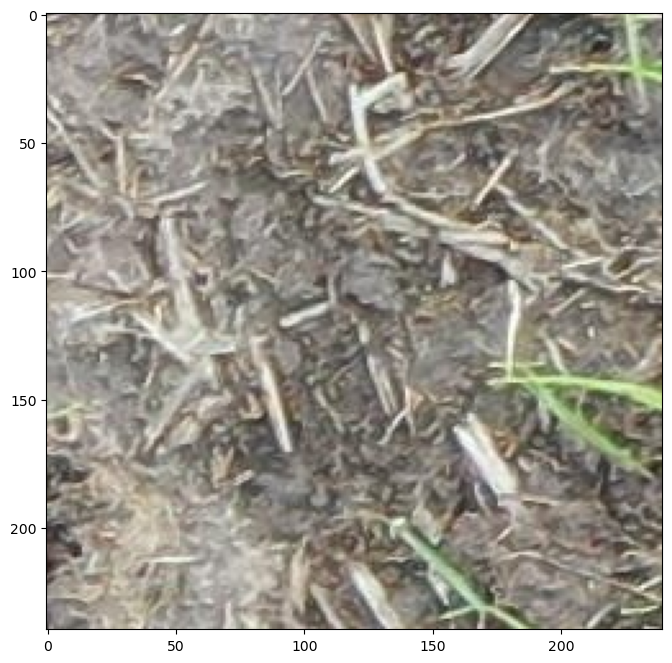

In [175]:
image = cv.imread(image_file)

im = cv.cvtColor(image, cv.COLOR_BGR2RGB)
fig = plt.figure(figsize=(12,8))
plt.imshow(im)
plt.show()

### Labels

In [176]:
labels_file = build_filename(dset=SUBSET, type='label', name=PROCESSING_FILE)

In [177]:
with open(labels_file, 'r') as file:
    lines = file.readlines()
    lines = [line.strip() for line in lines]
    labels = [line.split() for line in lines]

In [178]:
# Convierte de string a int/float
labels = [[int(value) if i == 0 else float(value) 
                for i, value in enumerate(label)] for label in labels]

class_id | x_center | y_center | width | height (normalized values)

In [179]:
df_labels = pd.DataFrame(labels, columns=['class_id', 'x_center', 'y_center', 'width', 'height'])

In [180]:
# Agrego un punto en cada esquina de la imagen para debugging
# Crear una nueva fila como un Series o DataFrame
upleft = pd.Series({'class_id': 0, 'x_center': 0, 'y_center': 0, 'width': 0, 'height': 0})
upright = pd.Series({'class_id': 0, 'x_center': 1, 'y_center': 0, 'width': 0, 'height': 0})
downleft = pd.Series({'class_id': 0, 'x_center': 0, 'y_center': 1, 'width': 0, 'height': 0})
downright = pd.Series({'class_id': 0, 'x_center': 1, 'y_center': 1, 'width': 0, 'height': 0})


# Concatenar la nueva fila al DataFrame existente
df_labels = pd.concat([df_labels, upleft.to_frame().T], ignore_index=True)
df_labels = pd.concat([df_labels, upright.to_frame().T], ignore_index=True)
df_labels = pd.concat([df_labels, downleft.to_frame().T], ignore_index=True)
df_labels = pd.concat([df_labels, downright.to_frame().T], ignore_index=True)

df_labels.tail(6)

,class_id,x_center,y_center,width,height
4,0,0.6375,0.9000,0.158333,0.133333
5,0,0.8125,0.9875,0.191667,0.029167
6,0,0.0000,0.0000,0.000000,0.000000
7,0,1.0000,0.0000,0.000000,0.000000
8,0,0.0000,1.0000,0.000000,0.000000
9,0,1.0000,1.0000,0.000000,0.000000


# Processing

In [181]:
H, W, _ = im.shape

### Absolute values

In [182]:
df_labels

,class_id,x_center,y_center,width,height
0,0,0.958333,0.095833,0.050000,0.187500
1,0,0.950000,0.150000,0.100000,0.141667
2,0,0.870833,0.654167,0.258333,0.116667
3,0,0.850000,0.654167,0.175000,0.150000
4,0,0.637500,0.900000,0.158333,0.133333
5,0,0.812500,0.987500,0.191667,0.029167
6,0,0.000000,0.000000,0.000000,0.000000
7,0,1.000000,0.000000,0.000000,0.000000
8,0,0.000000,1.000000,0.000000,0.000000
9,0,1.000000,1.000000,0.000000,0.000000


In [183]:
# Se transforma el formato de relativo a absoluto
df_labels_abs = label_transform(df_labels, 'absolute', im_height=H, im_width=W)
df_labels_abs

,class_id,x_center,y_center,width,height
0,0,230,23,12,45
1,0,228,36,24,34
2,0,209,157,62,28
3,0,204,157,42,36
4,0,153,216,38,32
5,0,195,237,46,7
6,0,0,0,0,0
7,0,240,0,0,0
8,0,0,240,0,0
9,0,240,240,0,0


### Bounding Boxes calculation

In [184]:
df_BBoxes = lbl_to_bb(df_labels_abs)
df_BBoxes

,class_id,x0,x1,y0,y1
0,0,224,236,0,45
1,0,216,240,19,53
2,0,178,240,143,171
3,0,183,225,139,175
4,0,134,172,200,232
5,0,172,218,233,240
6,0,0,0,0,0
7,0,240,240,0,0
8,0,0,0,240,240
9,0,240,240,240,240


# Visualización puntos

In [185]:
df_labels_abs

,class_id,x_center,y_center,width,height
0,0,230,23,12,45
1,0,228,36,24,34
2,0,209,157,62,28
3,0,204,157,42,36
4,0,153,216,38,32
5,0,195,237,46,7
6,0,0,0,0,0
7,0,240,0,0,0
8,0,0,240,0,0
9,0,240,240,0,0


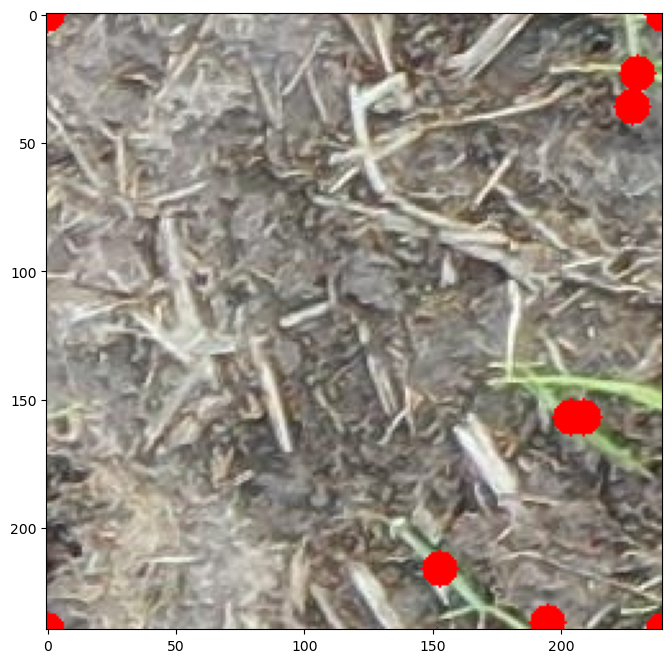

In [186]:
draw_points(im, df_labels_abs)

# Visualización Bounding Boxes

In [187]:
df_BBoxes

,class_id,x0,x1,y0,y1
0,0,224,236,0,45
1,0,216,240,19,53
2,0,178,240,143,171
3,0,183,225,139,175
4,0,134,172,200,232
5,0,172,218,233,240
6,0,0,0,0,0
7,0,240,240,0,0
8,0,0,0,240,240
9,0,240,240,240,240


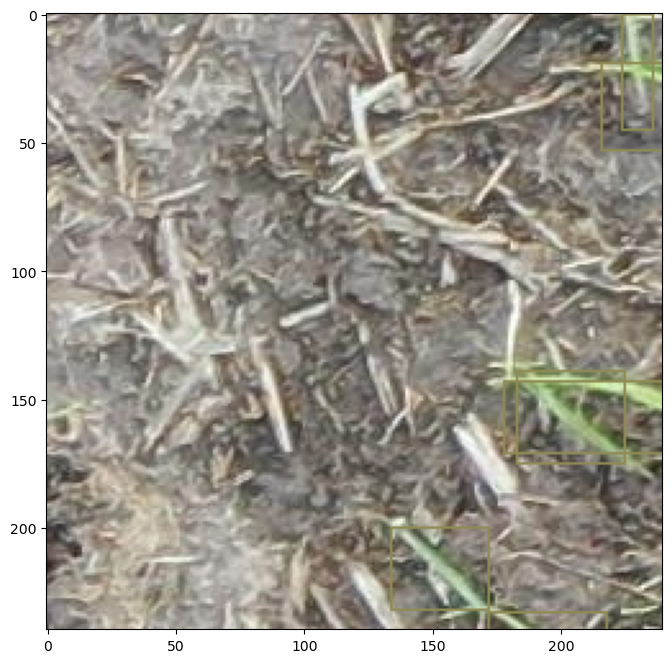

In [188]:
# Se deben enviar copias del array y dataframe por ser objetos mutables
draw_bb(im,df_BBoxes)

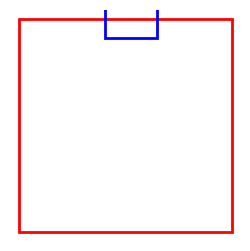

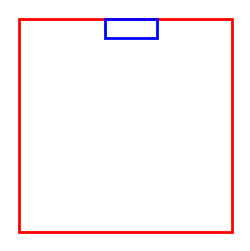

In [189]:
# Gráfico de BB abstracto
tile = "0 720 240 960 "
label = "97 682 156 742"
label1 = "97 720 156 742 "
test_label(tile,label)
test_label(tile,label1)